Using device: cpu
Starting training...
Epoch 1/3000 | Loss: 1.209e+00 | PDE: 2.004e-02 | IC: 5.553e-01 | BC: 6.341e-01 | time: 2.6s
Epoch 200/3000 | Loss: 1.601e-01 | PDE: 7.277e-03 | IC: 9.018e-02 | BC: 6.260e-02 | time: 275.7s
Epoch 400/3000 | Loss: 1.223e-01 | PDE: 1.044e-02 | IC: 7.216e-02 | BC: 3.965e-02 | time: 550.9s
Epoch 600/3000 | Loss: 8.586e-02 | PDE: 1.263e-02 | IC: 4.853e-02 | BC: 2.470e-02 | time: 824.2s
Epoch 800/3000 | Loss: 4.849e-02 | PDE: 1.081e-02 | IC: 2.171e-02 | BC: 1.597e-02 | time: 1103.8s
Epoch 1000/3000 | Loss: 2.667e-02 | PDE: 8.649e-03 | IC: 8.350e-03 | BC: 9.667e-03 | time: 1376.8s
Epoch 1200/3000 | Loss: 1.254e-02 | PDE: 5.473e-03 | IC: 2.619e-03 | BC: 4.449e-03 | time: 1651.7s
Epoch 1400/3000 | Loss: 8.249e-03 | PDE: 4.271e-03 | IC: 1.400e-03 | BC: 2.578e-03 | time: 1927.7s
Epoch 1600/3000 | Loss: 6.103e-03 | PDE: 3.466e-03 | IC: 9.112e-04 | BC: 1.726e-03 | time: 2201.0s
Epoch 1800/3000 | Loss: 4.664e-03 | PDE: 2.789e-03 | IC: 6.313e-04 | BC: 1.243e-03 

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


After LBFGS | Loss: 4.214e-06 | PDE: 3.388e-06 | IC: 2.963e-07 | BC: 5.287e-07
Training finished in 10735.6s
t=0.000 | rel L2 errors -> u: 1.188e-03, v: 1.053e-03, p: 2.182e-03


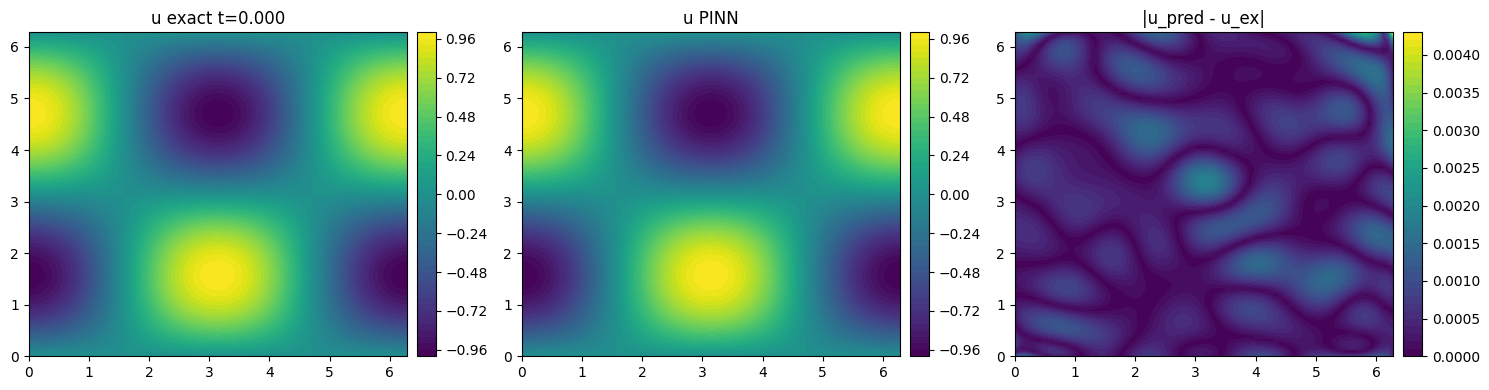

t=0.250 | rel L2 errors -> u: 1.065e-03, v: 9.979e-04, p: 1.794e-03


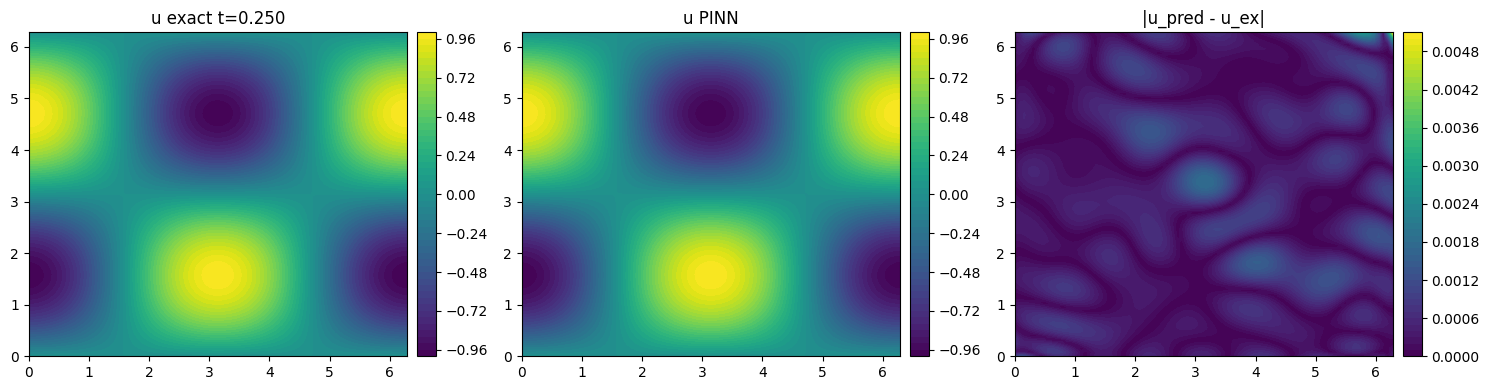

t=0.500 | rel L2 errors -> u: 1.025e-03, v: 1.016e-03, p: 2.162e-03


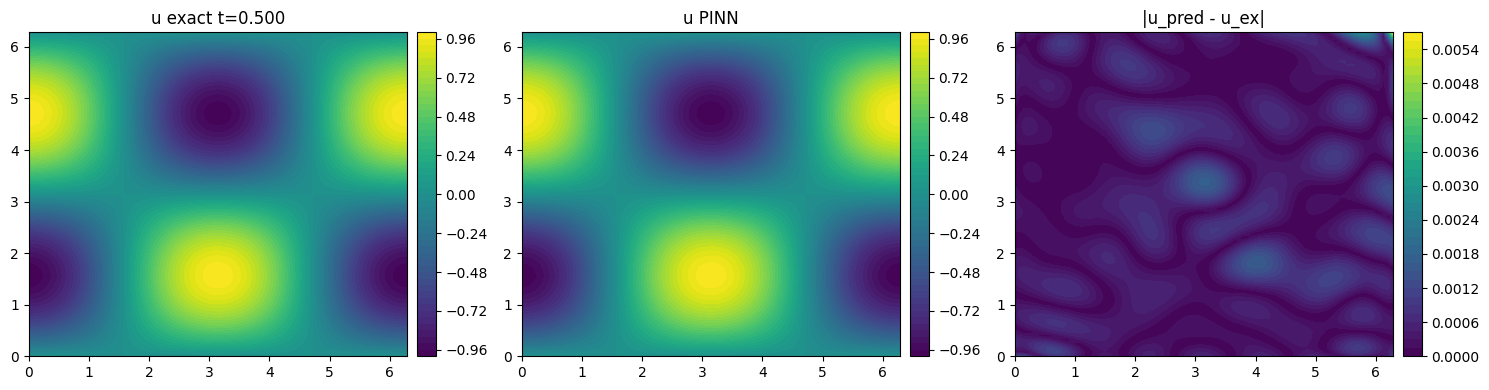

t=1.000 | rel L2 errors -> u: 1.314e-03, v: 1.343e-03, p: 4.994e-03


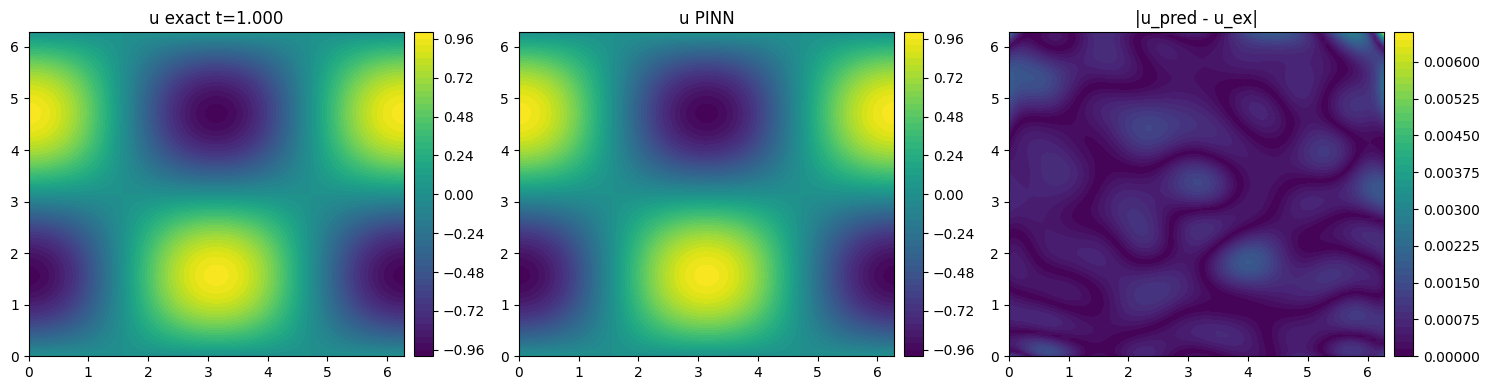

Done.


In [ ]:
"""
PINN for 2D Incompressible Navier-Stokes (Taylor-Green vortex)
---------------------------------------------------------------
This script implements a Physics-Informed Neural Network (PINN) in PyTorch
that learns the velocity field (u,v) and pressure p for the 2D Taylor-Green
vortex (an analytical solution of the incompressible Navier-Stokes equations).

Domain: x, y in [0, 2*pi], t in [0, T]
Analytical (Taylor-Green) solution used for supervision of IC/BC and validation.

Dependencies: torch, numpy, matplotlib

Usage: python pinn_navier_stokes_pytorch.py

Author: ChatGPT (GPT-5 Thinking mini)
"""

import math
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ----------------------------- Config ---------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# physical parameter
nu = 0.01  # kinematic viscosity (Re ~ O(100))

# domain
L = 2.0 * math.pi
T_final = 1.0

# network hyperparameters
layers = [3, 64, 64, 64, 64, 3]  # input (x,y,t) -> output (u,v,p)
activation = nn.Tanh

# training hyperparameters
n_collocation = 20000  # interior collocation points
n_ic = 2000            # initial condition points
n_bc = 2000            # boundary condition points (sampled)
lr = 1e-3
n_epochs_adam = 3000
use_lbfgs = True

# reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# ----------------------------- Utility functions ----------------------

def latin_hypercube_sampling(bounds, n_samples):
    # bounds: list of (low, high)
    D = len(bounds)
    result = np.zeros((n_samples, D))
    rng = np.random.default_rng()
    rng.shuffle(np.arange(n_samples))
    for i, (low, high) in enumerate(bounds):
        perm = rng.permutation(n_samples) + 1
        pts = (perm - rng.random(n_samples)) / n_samples
        result[:, i] = low + pts * (high - low)
    return result

# Analytical Taylor-Green vortex (for validation & BC/IC)
# u = -cos(x) sin(y) exp(-2*nu*t)
# v = sin(x) cos(y) exp(-2*nu*t)
# p = -1/4( cos(2x) + cos(2y) ) exp(-4*nu*t)

def taylor_green_solution(x, y, t, nu):
    # x,y,t can be numpy arrays
    exp1 = np.exp(-2.0 * nu * t)
    exp2 = np.exp(-4.0 * nu * t)
    u = -np.cos(x) * np.sin(y) * exp1
    v =  np.sin(x) * np.cos(y) * exp1
    p = -0.25 * (np.cos(2.0 * x) + np.cos(2.0 * y)) * exp2
    return u, v, p

# ----------------------------- Neural network -------------------------
class PINN(nn.Module):
    def __init__(self, layers, activation=nn.Tanh):
        super(PINN, self).__init__()
        self.activation = activation()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(self.activation)
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*layer_list)
        # Xavier initialization
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: tensor with shape (N,3)
        return self.net(x)

# helper for derivatives
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    else:
        g = gradients(u, x, order-1)
        return torch.autograd.grad(g, x, grad_outputs=torch.ones_like(g), create_graph=True, retain_graph=True)[0]

# ----------------------------- Data sampling --------------------------
# collocation points inside the domain (x,y,t)
bounds = [(0.0, L), (0.0, L), (0.0, T_final)]
X_f = latin_hypercube_sampling(bounds, n_collocation)
X_f = torch.tensor(X_f, dtype=torch.float32, device=device, requires_grad=True)

# initial condition (t=0)
X_ic = np.zeros((n_ic, 3))
X_ic[:,0:2] = np.random.rand(n_ic, 2) * L
X_ic[:,2] = 0.0
u_ic, v_ic, p_ic = taylor_green_solution(X_ic[:,0], X_ic[:,1], X_ic[:,2], nu)
X_ic = torch.tensor(X_ic, dtype=torch.float32, device=device)
U_ic = torch.tensor(np.stack([u_ic, v_ic, p_ic], axis=1), dtype=torch.float32, device=device)

# boundary points (we'll sample points on domain boundaries and use periodic BCs by comparing values at boundaries horizontally and vertically)
# For simplicity we'll sample boundary pairs and enforce equality (periodic)
# sample points on x=0 and x=L for same y,t; similarly for y=0 and y=L
n_bc_pairs = n_bc // 2
ys = np.random.rand(n_bc_pairs) * L
ts = np.random.rand(n_bc_pairs) * T_final
x0 = np.zeros(n_bc_pairs)
xL = np.ones(n_bc_pairs) * L
X_bc_x0 = np.stack([x0, ys, ts], axis=1)
X_bc_xL = np.stack([xL, ys, ts], axis=1)

xs = np.random.rand(n_bc_pairs) * L
y0 = np.zeros(n_bc_pairs)
yL = np.ones(n_bc_pairs) * L
X_bc_y0 = np.stack([xs, y0, ts], axis=1)
X_bc_yL = np.stack([xs, yL, ts], axis=1)

X_bc_pairs = np.vstack([X_bc_x0, X_bc_xL, X_bc_y0, X_bc_yL])
X_bc_pairs = torch.tensor(X_bc_pairs, dtype=torch.float32, device=device)

# exact values for boundaries from analytical solution (to compute periodic pair loss we will compute pairwise equality--but we can also use analytic values)
# we'll compute analytic values for each boundary point and use equality between corresponding periodic points
u_x0, v_x0, p_x0 = taylor_green_solution(X_bc_x0[:,0], X_bc_x0[:,1], X_bc_x0[:,2], nu)
u_xL, v_xL, p_xL = taylor_green_solution(X_bc_xL[:,0], X_bc_xL[:,1], X_bc_xL[:,2], nu)

u_y0, v_y0, p_y0 = taylor_green_solution(X_bc_y0[:,0], X_bc_y0[:,1], X_bc_y0[:,2], nu)
u_yL, v_yL, p_yL = taylor_green_solution(X_bc_yL[:,0], X_bc_yL[:,1], X_bc_yL[:,2], nu)

# stack analytic boundary values in matching order
U_bc_pairs = np.vstack([np.stack([u_x0, v_x0, p_x0], axis=1),
                        np.stack([u_xL, v_xL, p_xL], axis=1),
                        np.stack([u_y0, v_y0, p_y0], axis=1),
                        np.stack([u_yL, v_yL, p_yL], axis=1)])
U_bc_pairs = torch.tensor(U_bc_pairs, dtype=torch.float32, device=device)

# convert collocation to require_grad tensors
X_f = X_f.clone().detach().requires_grad_(True)

# ----------------------------- Model, optimizer ----------------------
model = PINN(layers, activation).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# LBFGS requires closure
if use_lbfgs:
    lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50000, tolerance_grad=1e-8, tolerance_change=1e-12, history_size=50)

mse_loss = nn.MSELoss()

# ----------------------------- Loss function -------------------------

def pinn_loss(model):
    # PDE residual loss on collocation points
    x_f = X_f[:,0:1]
    y_f = X_f[:,1:2]
    t_f = X_f[:,2:3]
    inp_f = torch.cat([x_f, y_f, t_f], dim=1)
    inp_f.requires_grad_(True)

    pred_f = model(inp_f)
    u = pred_f[:,0:1]
    v = pred_f[:,1:2]
    p = pred_f[:,2:3]

    # derivatives
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y_f, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_f, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]

    v_t = torch.autograd.grad(v, t_f, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_x = torch.autograd.grad(v, x_f, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_y = torch.autograd.grad(v, y_f, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x_f, grad_outputs=torch.ones_like(v_x), create_graph=True, retain_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y_f, grad_outputs=torch.ones_like(v_y), create_graph=True, retain_graph=True)[0]

    p_x = torch.autograd.grad(p, x_f, grad_outputs=torch.ones_like(p), create_graph=True, retain_graph=True)[0]
    p_y = torch.autograd.grad(p, y_f, grad_outputs=torch.ones_like(p), create_graph=True, retain_graph=True)[0]

    # PDE residuals
    f_u = u_t + (u * u_x + v * u_y) + p_x - nu * (u_xx + u_yy)
    f_v = v_t + (u * v_x + v * v_y) + p_y - nu * (v_xx + v_yy)
    f_c = u_x + v_y  # continuity

    l_pde = mse_loss(f_u, torch.zeros_like(f_u)) + mse_loss(f_v, torch.zeros_like(f_v)) + mse_loss(f_c, torch.zeros_like(f_c))

    # initial condition loss
    x_ic = X_ic[:,0:1]
    y_ic = X_ic[:,1:2]
    t_ic = X_ic[:,2:3]
    inp_ic = torch.cat([x_ic, y_ic, t_ic], dim=1)
    pred_ic = model(inp_ic)
    l_ic = mse_loss(pred_ic, U_ic)

    # periodic boundary loss: enforce analytic periodicity (we use analytic values to weakly constrain)
    inp_bc = X_bc_pairs
    pred_bc = model(inp_bc)
    l_bc = mse_loss(pred_bc, U_bc_pairs)

    loss = l_pde + l_ic + l_bc
    return loss, l_pde.detach().cpu().item(), l_ic.detach().cpu().item(), l_bc.detach().cpu().item()

# ----------------------------- Training loop ------------------------

print("Starting training...")
start_time = time.time()
for epoch in range(1, n_epochs_adam+1):
    optimizer.zero_grad()
    loss, l_pde, l_ic, l_bc = pinn_loss(model)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0 or epoch == 1:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch}/{n_epochs_adam} | Loss: {loss.item():.3e} | PDE: {l_pde:.3e} | IC: {l_ic:.3e} | BC: {l_bc:.3e} | time: {elapsed:.1f}s")

# optional LBFGS fine-tuning
if use_lbfgs:
    print("Starting LBFGS optimization...")
    def closure():
        lbfgs_optimizer.zero_grad()
        loss, l_pde, l_ic, l_bc = pinn_loss(model)
        loss.backward()
        return loss
    lbfgs_optimizer.step(closure)
    loss, l_pde, l_ic, l_bc = pinn_loss(model)
    print(f"After LBFGS | Loss: {loss.item():.3e} | PDE: {l_pde:.3e} | IC: {l_ic:.3e} | BC: {l_bc:.3e}")

train_time = time.time() - start_time
print(f"Training finished in {train_time:.1f}s")

# ----------------------------- Validation & Visualization ------------
# Evaluate at a grid and compare to analytical solution at several time snapshots

model.eval()

def predict_on_grid(t_snapshot, nx=100, ny=100):
    xs = np.linspace(0, L, nx)
    ys = np.linspace(0, L, ny)
    X, Y = np.meshgrid(xs, ys)
    TT = np.ones_like(X) * t_snapshot
    inp = np.stack([X.ravel(), Y.ravel(), TT.ravel()], axis=1)
    inp_t = torch.tensor(inp, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(inp_t).cpu().numpy()
    u_pred = pred[:,0].reshape((ny, nx))
    v_pred = pred[:,1].reshape((ny, nx))
    p_pred = pred[:,2].reshape((ny, nx))

    u_ex, v_ex, p_ex = taylor_green_solution(X, Y, TT, nu)
    return X, Y, u_pred, v_pred, p_pred, u_ex, v_ex, p_ex

# plot snapshots
snap_times = [0.0, 0.25*T_final, 0.5*T_final, T_final]
for t_snap in snap_times:
    X, Y, u_pred, v_pred, p_pred, u_ex, v_ex, p_ex = predict_on_grid(t_snap, nx=80, ny=80)

    err_u = np.linalg.norm(u_pred - u_ex) / np.linalg.norm(u_ex)
    err_v = np.linalg.norm(v_pred - v_ex) / np.linalg.norm(v_ex)
    err_p = np.linalg.norm(p_pred - p_ex) / np.linalg.norm(p_ex)
    print(f"t={t_snap:.3f} | rel L2 errors -> u: {err_u:.3e}, v: {err_v:.3e}, p: {err_p:.3e}")

    # Plot u field: exact vs pred and difference
    fig, axs = plt.subplots(1,3, figsize=(15,4))
    levels = 50
    im0 = axs[0].contourf(X, Y, u_ex, levels=levels)
    axs[0].set_title(f"u exact t={t_snap:.3f}")
    divider = make_axes_locatable(axs[0]); cax = divider.append_axes("right", size="5%", pad=0.1); fig.colorbar(im0, cax=cax)

    im1 = axs[1].contourf(X, Y, u_pred, levels=levels)
    axs[1].set_title("u PINN")
    divider = make_axes_locatable(axs[1]); cax = divider.append_axes("right", size="5%", pad=0.1); fig.colorbar(im1, cax=cax)

    im2 = axs[2].contourf(X, Y, np.abs(u_pred - u_ex), levels=levels)
    axs[2].set_title("|u_pred - u_ex|")
    divider = make_axes_locatable(axs[2]); cax = divider.append_axes("right", size="5%", pad=0.1); fig.colorbar(im2, cax=cax)

    plt.tight_layout()
    plt.show()

print("Done.")

In [2]:
torch.save(model.state_dict(), "pinn_taylor_green.pth")


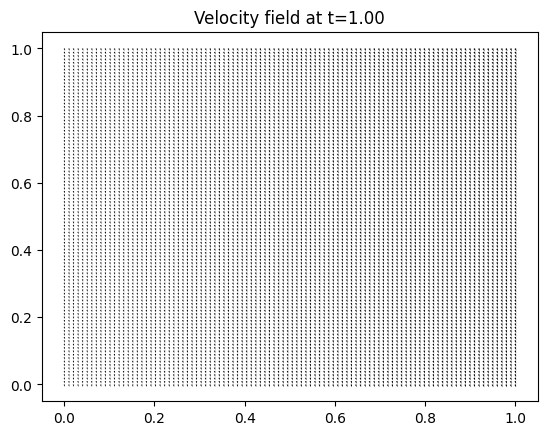

In [5]:
plt.quiver(X, Y, u_pred, v_pred)
plt.title(f"Velocity field at t={t_snap:.2f}")
plt.show()


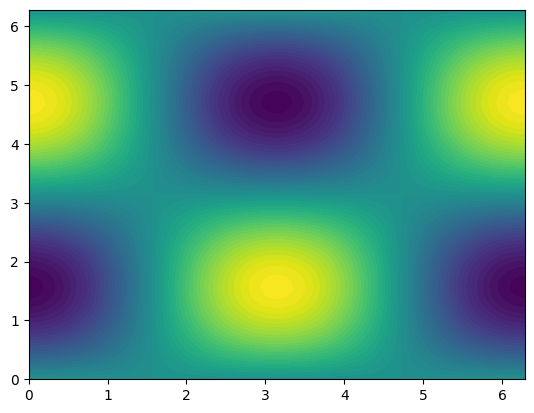

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, u_pred, levels=50)

def update(frame):
    t = frame / 10
    X, Y, u_pred, v_pred, p_pred, _, _, _ = predict_on_grid(t)
    for c in ax.collections: c.remove()
    ax.contourf(X, Y, u_pred, levels=50)
    ax.set_title(f"t={t:.2f}")
    return contour

ani = animation.FuncAnimation(fig, update, frames=20, interval=200)
plt.show()


In [ ]:
model.load_state_dict(torch.load("pinn_taylor_green.pth"))
model.eval()


PINN(
  (activation): Tanh()
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [ ]:
import os

# ======================================================
# Save predicted and exact fields as PNG plots
# ======================================================

# create data folder if not exists
os.makedirs("data", exist_ok=True)

# define snapshot times for saving
snap_times = [0.0, 0.5, 1.0]

for t_snap in snap_times:
    X, Y, u_pred, v_pred, p_pred, u_ex, v_ex, p_ex = predict_on_grid(t_snap, nx=100, ny=100)

    # compute absolute error
    u_err = np.abs(u_pred - u_ex)

    # ---------- Plot 1: u-field (exact) ----------
    plt.figure(figsize=(5,4))
    plt.contourf(X, Y, u_ex, levels=50, cmap="viridis")
    plt.colorbar(label="u (exact)")
    plt.title(f"Exact u-field t={t_snap:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(f"data/u_field_exact_t{t_snap:.2f}.png", dpi=300)
    plt.close()

    # ---------- Plot 2: u-field (PINN prediction) ----------
    plt.figure(figsize=(5,4))
    plt.contourf(X, Y, u_pred, levels=50, cmap="viridis")
    plt.colorbar(label="u (PINN)")
    plt.title(f"Predicted u-field t={t_snap:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(f"data/u_field_pred_t{t_snap:.2f}.png", dpi=300)
    plt.close()

    # ---------- Plot 3: error map ----------
    plt.figure(figsize=(5,4))
    plt.contourf(X, Y, u_err, levels=50, cmap="magma")
    plt.colorbar(label="|u_pred - u_ex|")
    plt.title(f"Error map t={t_snap:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(f"data/error_map_t{t_snap:.2f}.png", dpi=300)
    plt.close()

    print(f"✅ Saved plots for t={t_snap:.2f}")

print("All plots saved in /data folder.")


✅ Saved plots for t=0.00
✅ Saved plots for t=0.50
✅ Saved plots for t=1.00
All plots saved in /data folder.


In [ ]:
plt.figure(figsize=(6,5))
plt.quiver(X, Y, u_pred, v_pred, scale=10)
plt.title(f"Velocity vectors (PINN) t={t_snap:.2f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.savefig(f"data/velocity_vectors_t{t_snap:.2f}.png", dpi=300)
plt.close()


In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# ======================================================
# Physics parameters (Taylor–Green vortex)
# ======================================================
L = 1.0
nu = 0.01 / math.pi  # viscosity

# ======================================================
# Analytical Taylor–Green vortex solution
# ======================================================
def taylor_green_solution(X, Y, T, nu):
    u = -np.cos(math.pi * X) * np.sin(math.pi * Y) * np.exp(-2 * (math.pi**2) * nu * T)
    v =  np.sin(math.pi * X) * np.cos(math.pi * Y) * np.exp(-2 * (math.pi**2) * nu * T)
    p = -0.25 * (np.cos(2 * math.pi * X) + np.cos(2 * math.pi * Y)) * np.exp(-4 * (math.pi**2) * nu * T)
    return u, v, p

# ======================================================
# PINN model definition (same as training)
# ======================================================
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        # Original model used nn.Sequential with self.net
        self.activation = nn.Tanh()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(self.activation)
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*layer_list)

    def forward(self, x):
        # Forward pass should use self.net as in the original model
        return self.net(x)

# ======================================================
# Load trained model
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

layers = [3, 64, 64, 64, 64, 3]  # input: (x, y, t), output: (u, v, p)
model = PINN(layers).to(device)
model.load_state_dict(torch.load("/content/pinn_taylor_green.pth", map_location=device))
model.eval()

print("✅ Model loaded successfully from /content/pinn_taylor_green.pth")

# ======================================================
# Predict on grid
# ======================================================
def predict_on_grid(t_snapshot, nx=100, ny=100):
    xs = np.linspace(0, L, nx)
    ys = np.linspace(0, L, ny)
    X, Y = np.meshgrid(xs, ys)
    TT = np.ones_like(X) * t_snapshot
    inp = np.stack([X.ravel(), Y.ravel(), TT.ravel()], axis=1)
    inp_t = torch.tensor(inp, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(inp_t).cpu().numpy()
    u_pred = pred[:,0].reshape((ny, nx))
    v_pred = pred[:,1].reshape((ny, nx))
    p_pred = pred[:,2].reshape((ny, nx))
    u_ex, v_ex, p_ex = taylor_green_solution(X, Y, TT, nu)
    return X, Y, u_pred, v_pred, p_pred, u_ex, v_ex, p_ex

# ======================================================
# Save plots for multiple time snapshots
# ======================================================
os.makedirs("/content/data", exist_ok=True)
snap_times = [0.0, 0.5, 1.0]

for t_snap in snap_times:
    X, Y, u_pred, v_pred, p_pred, u_ex, v_ex, p_ex = predict_on_grid(t_snap)
    u_err = np.abs(u_pred - u_ex)

    # Exact field
    plt.figure(figsize=(5,4))
    plt.contourf(X, Y, u_ex, levels=50, cmap="viridis")
    plt.colorbar(label="u (exact)")
    plt.title(f"Exact u-field t={t_snap:.2f}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(f"/content/data/u_field_exact_t{t_snap:.2f}.png", dpi=300)
    plt.close()

    # Predicted field
    plt.figure(figsize=(5,4))
    plt.contourf(X, Y, u_pred, levels=50, cmap="viridis")
    plt.colorbar(label="u (PINN)")
    plt.title(f"Predicted u-field t={t_snap:.2f}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(f"/content/data/u_field_pred_t{t_snap:.2f}.png", dpi=300)
    plt.close()

    # Error map
    plt.figure(figsize=(5,4))
    plt.contourf(X, Y, u_err, levels=50, cmap="magma")
    plt.colorbar(label="|u_pred - u_ex|")
    plt.title(f"Error map t={t_snap:.2f}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(f"/content/data/error_map_t{t_snap:.2f}.png", dpi=300)
    plt.close()

    print(f"✅ Saved plots for t={t_snap:.2f}")

print("🎉 All plots saved under /content/data/")

Using device: cpu
✅ Model loaded successfully from /content/pinn_taylor_green.pth
✅ Saved plots for t=0.00
✅ Saved plots for t=0.50
✅ Saved plots for t=1.00
🎉 All plots saved under /content/data/


In [ ]:
!